In [1]:
import gymnasium as gym
import pdecontrolgym
import numpy as np
import math
import matplotlib.pyplot as plt
import stable_baselines3
import time
from utils import set_size
from utils import linestyle_tuple
from utils import load_csv
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback

In [2]:
# Print Versioning
print("Gym version", gym.__version__)
print("Numpy version", np.__version__)
print("Stable Baselines3 version", stable_baselines3.__version__)

Gym version 0.28.1
Numpy version 1.26.2
Stable Baselines3 version 2.2.1


Helper Functions for the Environment

In [3]:
# NO NOISE
def noiseFunc(state):
    return state

# Chebyshev Polynomial Beta Functions
def solveBetaFunction(x, gamma):
    beta = np.zeros(len(x), dtype=np.float32)
    for idx, val in enumerate(x):
        beta[idx] = 5*math.cos(gamma*math.acos(val))
    return beta

# Kernel function solver for backstepping
def solveKernelFunction(theta):
    kappa = np.zeros(len(theta))
    for i in range(0, len(theta)):
        kernelIntegral = 0
        for j in range(0, i):
            kernelIntegral += (kappa[i-j]*theta[j])*dx
        kappa[i] = kernelIntegral  - theta[i]
    return np.flip(kappa)

# Control convolution solver
def solveControl(kernel, u):
    res = 0
    for i in range(len(u)):
        res += kernel[i]*u[i]
    return res*1e-2

# Set initial condition function here
def getInitialCondition(nx):
    return np.ones(nx)*np.random.uniform(1, 10)

# Returns beta functions passed into PDE environment. Currently gamma is always
# set to 7.35, but this can be modified for further problesms
def getBetaFunction(nx, X):
    return solveBetaFunction(np.linspace(0, X, nx), 7.35)


In [4]:
# Timestep and spatial step for PDE Solver
T = 5
dt = 1e-4
dx = 1e-2
X = 1

In [5]:
# Backstepping does not need to normalize actions to be between -1 and 1, so normalize is set to False. Otherwise, 
# parameters are same as RL algorithms
hyperbolicParameters = {
        "T": T, 
        "dt": dt, 
        "X": X,
        "dx": dx, 
        "sensing_loc": "full", 
        "control_type": "Dirchilet", 
        "sensing_type": None,
        "sensing_noise_func": lambda state: state,
        "limit_pde_state_size": True,
        "max_state_value": 1e10,
        "max_control_value": 20,
        "reward_norm": 2, 
        "reward_horizon": "temporal",
        "reward_average_length": 10,
        "truncate_penalty": -1e3, 
        "terminate_reward": 3e2, 
        "reset_init_condition_func": getInitialCondition,
        "reset_recirculation_func": getBetaFunction,
        "control_sample_rate": 0.1,
        "normalize": None,
}

hyperbolicParametersBackstepping = hyperbolicParameters.copy()
hyperbolicParametersBackstepping["normalize"] = False

hyperbolicParametersRL = hyperbolicParameters.copy()
hyperbolicParametersRL["normalize"] = True

In [6]:
# Make environments
envRL = gym.make("PDEControlGym-HyperbolicPDE1D", hyperbolicParams=hyperbolicParametersRL)
envBcks = gym.make("PDEControlGym-HyperbolicPDE1D", hyperbolicParams=hyperbolicParametersBackstepping)

In [7]:
# Save a checkpoint every 10000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=10000,
  save_path="./logsPPO",
  name_prefix="rl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

# TRAINING. SKIP IF WANT TO USE PRELOADED MODELS
# Train PPO
model = PPO("MlpPolicy",envRL, verbose=1, tensorboard_log="./tb/")
# Train for 500k timesteps
#model.learn(total_timesteps=1e6, callback=checkpoint_callback)

# Train SAC
model = SAC("MlpPolicy",envRL, verbose=1, tensorboard_log="./tb/")
# Train for 500k timesteps
#model.learn(total_timesteps=5e5, callback=checkpoint_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


1000000


Text(0, 0.5, 'Average Reward')

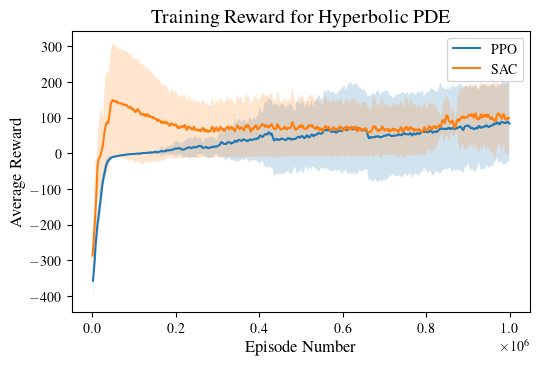

In [8]:
# Visualize Rewards

# In TensorBoard, save the avg rewards plot as a csv and then put their paths here
# Set your tensorboard avg_rew paths. WILL NEED UPDATING
filenamesPPO = ["PPOData/test1.csv", "PPOData/test2.csv", "PPOData/test3.csv", "PPOData/test4.csv", "PPOData/test5.csv"]
filenamesSAC = ["SACData/SAC_18.csv", "SACData/SAC_19.csv", "SACData/SAC_20.csv", "SACData/SAC_21.csv", "SACData/SAC_23.csv"]

timePPOArr = []
rewardPPOArr = []
for name in filenamesPPO:
    times, rewards = load_csv(name)
    timePPOArr.append(times)
    rewardPPOArr.append(rewards)

timeSACArr = []
rewardSACArr = []
for name in filenamesSAC:
    times, rewards = load_csv(name)
    timeSACArr.append(times)
    rewardSACArr.append(rewards)

# takes max amount of timesteps all data has
maxTimestep = np.inf
for data in timePPOArr:
    maxTimestep = min(maxTimestep, data[-1])
for data in timeSACArr:
    maxTimestep = min(maxTimestep, data[-1])
print(maxTimestep)

# remove data after minTimestep
maxDataSeqPPO = []
for data in timePPOArr:
    for i in range(len(data)):
        if data[i] >= maxTimestep:
            maxDataSeqPPO.append(i)
            break
maxDataSeqSAC = []
for data in timeSACArr:
    for i in range(len(data)):
        if data[i] >= maxTimestep:
            maxDataSeqSAC.append(i)
            break

# Get mean and std of each value at time step 
rewardArrCleanPPO = []
for i, data in enumerate(rewardPPOArr):
    rewardArrCleanPPO.append(data[:min(maxDataSeqPPO)])
rewardArrPPO = np.array(rewardArrCleanPPO)
meanArrPPO = rewardArrPPO.mean(axis=0)
stdArrPPO = rewardArrPPO.std(axis=0)

rewardArrCleanSAC = []
for i, data in enumerate(rewardSACArr):
    rewardArrCleanSAC.append(data[:min(maxDataSeqSAC)])
rewardArrSAC = np.array(rewardArrCleanSAC)
meanArrSAC = rewardArrSAC.mean(axis=0)
stdArrSAC = rewardArrSAC.std(axis=0)

# Set size according to latex textwidth
fig = plt.figure(figsize=set_size(432, 0.99, (1, 1), height_add=0))
ax = fig.subplots(ncols=1)
t = timePPOArr[0]
x = t[:maxDataSeqPPO[0]]
mean = meanArrPPO
std = stdArrPPO
# 95 confidence interval
cis = (mean - 2*std, mean + 2*std)
ax.plot(x, mean, label="PPO")
ax.fill_between(x, cis[0], cis[1], alpha=0.2)

t = timeSACArr[0]
x = t[:min(maxDataSeqSAC)]
mean = meanArrSAC
std = stdArrSAC
# 95 confidence interval
cis = (mean - 2*std, mean + 2*std)
ax.plot(x, mean, label="SAC")
ax.fill_between(x, cis[0], cis[1], alpha=0.2)

plt.legend()
plt.title("Training Reward for Hyperbolic PDE")
plt.xlabel("Episode Number")
plt.ylabel("Average Reward")

In [9]:
# Load RL models. # DUMMY ARGUMENTS NEED TO BE MODIFIED
ppoModelPath = "./ppoBestModelHyperbolic"
sacModelPath = "./sacBestModelHyperbolic"
ppoModel = PPO.load(ppoModelPath)
sacModel = SAC.load(sacModelPath)

# For backstepping controller
spatial = np.linspace(dx, X, int(round(X/dx)))
beta = solveBetaFunction(spatial, 7.35)

In [10]:
# Runs a single epsiode calculation
# Parameter varies. For SAC and PPO it is the model itself
# For backstepping it is the beta function
def runSingleEpisode(model, env, parameter):
    terminate = False
    truncate = False

    # Holds the resulting states
    uStorage = []

    # Reset Environment
    obs,__ = env.reset()
    uStorage.append(obs)

    i = 0
    rew = 0
    while not truncate and not terminate:
        # use backstepping controller
        action = model(obs, parameter)
        obs, rewards, terminate, truncate, info = env.step(action)
        uStorage.append(obs)
        rew += rewards 
    u = np.array(uStorage)
    return rew, u

In [11]:
# Define Controllers
def bcksController(obs, beta):
    kernel = solveKernelFunction(beta)
    return solveControl(kernel, obs)

def RLController(obs, model):
    action, _state = model.predict(obs)
    return action

def openLoopController(_, _a):
    return 0

In [12]:
# Run comparisons
num_instances = 50
# Backstepping. Controller is slow so this will take some time.
total_bcks_reward = 0
s = time.time()
for i in range(num_instances):
    rew, _ = runSingleEpisode(bcksController, envBcks, beta)
    total_bcks_reward += rew
print("Average Instance calculation Time for backstepping controller:", (time.time()-s)/num_instances)
print("Backstepping Reward Average:", total_bcks_reward/num_instances)

Average Instance calculation Time for backstepping controller: 0.23214139461517333
Backstepping Reward Average: 239.5663642221024


In [13]:
# PPO
total_ppo_reward = 0
s = time.time()
for i in range(num_instances):
    rew, _ = runSingleEpisode(RLController, envRL, ppoModel)
    total_ppo_reward += rew
print("Average Instance calculation Time for PPO controller:", (time.time()-s)/num_instances)
print("PPO Reward Average:", total_ppo_reward/num_instances)

Average Instance calculation Time for PPO controller: 0.3445195770263672
PPO Reward Average: 3.192141542434692


In [14]:
# SAC
total_sac_reward = 0
s = time.time()
for i in range(num_instances):
    rew, _ = runSingleEpisode(RLController, envRL, sacModel)
    total_sac_reward += rew
print("Average Instance calculation Time for SAC controller:", (time.time()-s)/num_instances)
print("SAC Reward Average:", total_sac_reward/num_instances)

Average Instance calculation Time for SAC controller: 0.347135329246521
SAC Reward Average: 3.067676010131836


In [15]:
# PLOT EXAMPLE PROBLEMS.

# First Build Same Initial Condition Environments
# Set initial condition function here
def getInitialConditionTen(nx):
    return np.ones(nx)*10

def getInitialConditionOne(nx):
    return np.ones(nx)*1

hyperbolicParametersBacksteppingTen = hyperbolicParametersBackstepping.copy()
hyperbolicParametersBacksteppingTen["reset_init_condition_func"] = getInitialConditionTen

hyperbolicParametersBacksteppingOne = hyperbolicParametersBackstepping.copy()
hyperbolicParametersBacksteppingOne["reset_init_condition_func"] = getInitialConditionOne

hyperbolicParametersRLTen = hyperbolicParametersRL.copy()
hyperbolicParametersRLTen["reset_init_condition_func"] = getInitialConditionTen

hyperbolicParametersRLOne = hyperbolicParametersRL.copy()
hyperbolicParametersRLOne["reset_init_condition_func"] = getInitialConditionOne

# Make environments
envBcksTen = gym.make("PDEControlGym-HyperbolicPDE1D", hyperbolicParams=hyperbolicParametersBacksteppingTen)
envBcksOne = gym.make("PDEControlGym-HyperbolicPDE1D", hyperbolicParams=hyperbolicParametersBacksteppingOne)

envRLTen = gym.make("PDEControlGym-HyperbolicPDE1D", hyperbolicParams=hyperbolicParametersRLTen)
envRLOne = gym.make("PDEControlGym-HyperbolicPDE1D", hyperbolicParams=hyperbolicParametersRLOne)

In [16]:
rewBcksTen, uBcksTen = runSingleEpisode(bcksController, envBcksTen, beta)
rewBcksOne, uBcksOne = runSingleEpisode(bcksController, envBcksOne, beta)

rewPPOTen, uPPOTen = runSingleEpisode(RLController, envRLTen, ppoModel)
rewPPOOne, uPPOOne = runSingleEpisode(RLController, envRLOne, ppoModel)

rewSACTen, uSACTen = runSingleEpisode(RLController, envRLTen, sacModel)
rewSACOne, uSACOne = runSingleEpisode(RLController, envRLOne, sacModel)

rewOpenTen,uOpenTen = runSingleEpisode(openLoopController, envBcksTen, _)
rewOpenTen,uOpenOne = runSingleEpisode(openLoopController, envBcksOne, _)

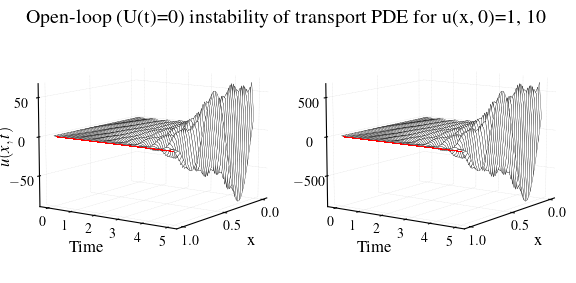

In [17]:
# PLOT OPENLOOOP EXAMPLE. PLOTS ARE NOT SCALED THE SAME ON Z SO MAY HAVE TO ADJUST
fig = plt.figure(figsize=set_size(433, 0.99, (1, 2), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.suptitle(r"Open-loop (U(t)=0) instability of transport PDE for u(x, 0)=1, 10")
subfig.subplots_adjust(left=0.03, bottom=0.05, right=1, top=0.95, wspace=0, hspace=0)

spatial = np.linspace(dx, X, int(round(X/dx)))
temporal = np.linspace(0, T, len(uPPOOne))
meshx, mesht = np.meshgrid(spatial, temporal)

ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axes in ax:
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1,1,1))

ax[0].view_init(10, 35)
ax[0].set_xlabel("x", labelpad=-3)
ax[1].set_xlabel("x", labelpad=-3)
ax[0].set_ylabel("Time", labelpad=-3)
ax[1].set_ylabel("Time", labelpad=-3)
ax[0].set_zlabel(r"$u(x, t)$", rotation=90, labelpad=-7)

ax[0].zaxis.set_rotate_label(False)
ax[0].set_xticks([0, 0.5, 1])
ax[0].tick_params(axis='x', which='major', pad=-3)
ax[1].tick_params(axis='x', which='major', pad=-3)
ax[0].tick_params(axis='y', which='major', pad=-3)
ax[1].tick_params(axis='y', which='major', pad=-3)
ax[0].tick_params(axis='z', which='major', pad=-1)
ax[1].tick_params(axis='z', which='major', pad=-1)

ax[0].plot_surface(meshx, mesht, uOpenOne, edgecolor="black",lw=0.2, rstride=50, cstride=2, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(len(temporal))
vals = (uOpenOne.transpose())[-1] 
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.1, antialiased=False, rasterized=False)
 
ax[1].plot_surface(meshx, mesht, uOpenTen, edgecolor="black",lw=0.2, rstride=50, cstride=2, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[1].view_init(10, 35)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
test = np.ones(len(temporal))
vals = (uOpenTen.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.1, antialiased=False, rasterized=False)

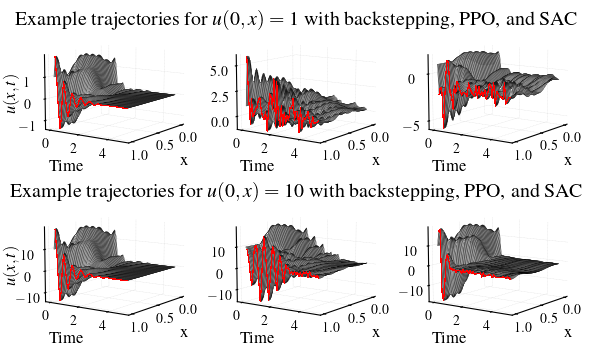

In [18]:
# PLOT EACH EXAMPLE. PLOTS ARE NOT SCALED THE SAME ON Z SO MAY HAVE TO ADJUST
fig = plt.figure(figsize=set_size(433, 0.99, (2, 3), height_add=1))
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"Example trajectories for $u(0, x)=1$ with backstepping, PPO, and SAC")
subfig.subplots_adjust(left=0.03, bottom=0.05, right=1, top=0.95, wspace=0, hspace=0)
X = 1
dx = 1e-2
T = 5
spatial = np.linspace(dx, X, int(round(X/dx)))
temporal = np.linspace(0, T, len(uPPOOne))
meshx, mesht = np.meshgrid(spatial, temporal)

ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})

for axes in ax:
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1,1,1))

ax[0].view_init(10, 35)
ax[0].set_xlabel("x", labelpad=-3)
ax[1].set_xlabel("x", labelpad=-3)
ax[2].set_xlabel("x", labelpad=-3)
ax[0].set_ylabel("Time", labelpad=-3)
ax[2].set_ylabel("Time", labelpad=-3)
ax[1].set_ylabel("Time", labelpad=-3)
ax[0].set_zlabel(r"$u(x, t)$", rotation=90, labelpad=-7)

ax[0].zaxis.set_rotate_label(False)
ax[0].set_xticks([0, 0.5, 1])
ax[0].tick_params(axis='x', which='major', pad=-3)
ax[1].tick_params(axis='x', which='major', pad=-3)
ax[2].tick_params(axis='x', which='major', pad=-3)
ax[0].tick_params(axis='y', which='major', pad=-3)
ax[1].tick_params(axis='y', which='major', pad=-3)
ax[2].tick_params(axis='y', which='major', pad=-3)
ax[0].tick_params(axis='z', which='major', pad=-1)
ax[1].tick_params(axis='z', which='major', pad=-1)
ax[2].tick_params(axis='z', which='major', pad=-1)

ax[0].plot_surface(meshx, mesht, uBcksOne, edgecolor="black",lw=0.2, rstride=50, cstride=1, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(len(temporal))
vals = (uBcksOne.transpose())[-1] 
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.1, antialiased=False, rasterized=False)
 
ax[1].plot_surface(meshx, mesht, uPPOOne, edgecolor="black",lw=0.2, rstride=50, cstride=1, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[1].view_init(10, 35)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
test = np.ones(len(temporal))
vals = (uPPOOne.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.1, antialiased=False, rasterized=False)
 
ax[2].plot_surface(meshx, mesht, uSACOne, edgecolor="black",lw=0.2, rstride=50, cstride=1, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[2].view_init(10, 35)
ax[2].zaxis.set_rotate_label(False)
ax[2].set_xticks([0, 0.5, 1])
test = np.ones(len(temporal))
vals = (uSACOne.transpose())[-1] 
ax[2].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.1, antialiased=False, rasterized=False)

subfig = subfigs[1]
subfig.suptitle(r"Example trajectories for $u(0, x)=10$ with backstepping, PPO, and SAC")
subfig.subplots_adjust(left=0.03, bottom=0.05, right=1, top=0.95, wspace=0, hspace=0)
X = 1
dx = 1e-2
T = 5
spatial = np.linspace(dx, X, int(round(X/dx)))
temporal = np.linspace(0, T, len(uPPOOne))
meshx, mesht = np.meshgrid(spatial, temporal)

ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})

for axes in ax:
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1,1,1))

ax[0].view_init(10, 35)
ax[0].set_xlabel("x", labelpad=-3)
ax[1].set_xlabel("x", labelpad=-3)
ax[2].set_xlabel("x", labelpad=-3)
ax[0].set_ylabel("Time", labelpad=-3)
ax[2].set_ylabel("Time", labelpad=-3)
ax[1].set_ylabel("Time", labelpad=-3)
ax[0].set_zlabel(r"$u(x, t)$", rotation=90, labelpad=-7)

ax[0].zaxis.set_rotate_label(False)
ax[0].set_xticks([0, 0.5, 1])
ax[0].tick_params(axis='x', which='major', pad=-3)
ax[1].tick_params(axis='x', which='major', pad=-3)
ax[2].tick_params(axis='x', which='major', pad=-3)
ax[0].tick_params(axis='y', which='major', pad=-3)
ax[1].tick_params(axis='y', which='major', pad=-3)
ax[2].tick_params(axis='y', which='major', pad=-3)
ax[0].tick_params(axis='z', which='major', pad=-1)
ax[1].tick_params(axis='z', which='major', pad=-1)
ax[2].tick_params(axis='z', which='major', pad=-1)

ax[0].plot_surface(meshx, mesht, uBcksTen, edgecolor="black",lw=0.2, rstride=50, cstride=1, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(len(temporal))
vals = (uBcksTen.transpose())[-1] 
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.1, antialiased=False, rasterized=False)
 
ax[1].plot_surface(meshx, mesht, uPPOTen, edgecolor="black",lw=0.2, rstride=50, cstride=1, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[1].view_init(10, 35)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
test = np.ones(len(temporal))
vals = (uPPOTen.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.1, antialiased=False, rasterized=False)
 
ax[2].plot_surface(meshx, mesht, uSACTen, edgecolor="black",lw=0.2, rstride=50, cstride=1, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[2].view_init(10, 35)
ax[2].zaxis.set_rotate_label(False)
ax[2].set_xticks([0, 0.5, 1])
test = np.ones(len(temporal))
vals = (uSACTen.transpose())[-1] 
ax[2].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.1, antialiased=False, rasterized=False)



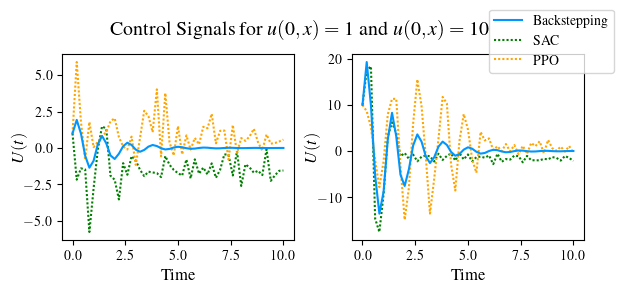

In [19]:
# BUILD CONTROL SIGNAL PLOTS 
fig = plt.figure(figsize=set_size(433, 0.99, (1, 2), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.suptitle(r"Control Signals for $u(0, x)=1$ and $u(0, x)=10$")
subfig.subplots_adjust(left=0.1, bottom=0.2, right=.98, top=0.86, wspace=0.25, hspace=0.1)
X = 1
dx = 1e-2
T = 10
spatial = np.linspace(dx, X, int(round(X/dx)))
temporal = np.linspace(0, T, len(uPPOOne))
ax = subfig.subplots(nrows=1, ncols=2)
l2, = ax[0].plot(temporal, uSACOne.transpose()[-1], label="SAC", linestyle=linestyle_tuple[2][1], color="green")
l1, = ax[0].plot(temporal, uPPOOne.transpose()[-1], label="PPO", linestyle=linestyle_tuple[2][1], color="orange")
l3, = ax[0].plot(temporal, uBcksOne.transpose()[-1], label="Backstepping", color="#0096FF")
ax[0].set_xlabel("Time")
ax[0].set_ylabel(R"$U(t)$", labelpad=-2)

l2, = ax[1].plot(temporal, uSACTen.transpose()[-1], label="SAC", linestyle=linestyle_tuple[2][1], color="green")
l1, = ax[1].plot(temporal, uPPOTen.transpose()[-1], label="PPO", linestyle=linestyle_tuple[2][1], color="orange")
l3, = ax[1].plot(temporal, uBcksTen.transpose()[-1], label="Backstepping", color="#0096FF")
ax[1].set_xlabel("Time")
ax[1].set_ylabel(r"$U(t)$", labelpad=-2)
plt.legend([l1, l2, l3], ["PPO", "SAC", "Backstepping"], loc="lower left", bbox_to_anchor=[.56,.86], reverse=True)

In [20]:
# PDE L2 Error
def getPDEl2(u, uhat):
    nt = len(u)
    nx = len(u[0])
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error)
        pdeError[i-1] = error
    return pdeError

In [21]:
# Share Rewards and L2 Norms for each problem
print(("InitialCondition\tModel Trained\tHyperbolic1D Rewards\tHyperbolic1DTotalL2Norm").expandtabs(30))
print(("u(x, 0)=1\tBackstepping\t" + str(rewBcksOne) +"\t" + str(sum(getPDEl2(uBcksOne, np.zeros(uBcksOne.shape))))).expandtabs(30))
print(("u(x, 0)=1\tPPO\t" + str(rewPPOOne) +"\t" + str(sum(getPDEl2(uPPOOne, np.zeros(uBcksOne.shape))))).expandtabs(30))
print(("u(x, 0)=1\tSAC\t" + str(rewSACOne) +"\t" + str(sum(getPDEl2(uSACOne, np.zeros(uBcksOne.shape))))).expandtabs(30))
print(("u(x, 0)=10\tBackstepping\t" + str(rewBcksTen) +"\t" + str(sum(getPDEl2(uBcksTen, np.zeros(uBcksOne.shape))))).expandtabs(30))
print(("u(x, 0)=10\tPPO\t" + str(rewPPOTen) +"\t" + str(sum(getPDEl2(uPPOTen, np.zeros(uBcksOne.shape))))).expandtabs(30))
print(("u(x, 0)=10\tSAC\t" + str(rewSACTen) +"\t" + str(sum(getPDEl2(uSACTen, np.zeros(uBcksOne.shape))))).expandtabs(30))

InitialCondition              Model Trained                 Hyperbolic1D Rewards          Hyperbolic1DTotalL2Norm
u(x, 0)=1                     Backstepping                  289.83798764991013            106.08644131330854
u(x, 0)=1                     PPO                           0.25653076171875              534.70419961105
u(x, 0)=1                     SAC                           -0.6083335876464844           714.2938863072932
u(x, 0)=10                    Backstepping                  198.3798030613661             1060.8641808569605
u(x, 0)=10                    PPO                           5.664868354797363             1798.3591704479468
u(x, 0)=10                    SAC                           6.915875434875488             1385.3778829151902
